In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
import os
from sklearn.model_selection import GridSearchCV
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import hyperopt.pyll.stochastic
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# pre-processing
df = pd.read_csv("master_data.csv")
df['RS%'] = df['RS%'].str.rstrip('%').astype('float') / 100.0
df['SB%'] = df['SB%'].str.rstrip('%').astype('float') / 100.0
df = df.dropna()
train, test = train_test_split(df)
xcols = ["Age", "G", "R", "H", "HR", "RBI", "SB", "SO", "BA", "SLG", "OPS", "Value Ranking", "WPA", "RS%", "SB%", "ISO"]
xcols_alt = ["R", "H", "HR", "RBI", "SO", "OPS", "Value Ranking"]

Train Accuracy: 92.537%
Valid Accuracy: 93.553%


<AxesSubplot:>

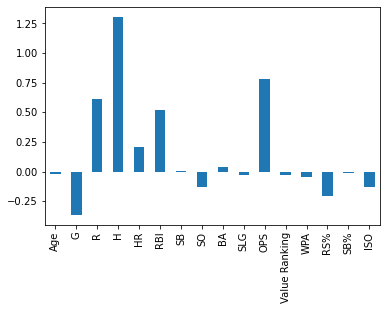

In [3]:
# Logistic Reg
model = Pipeline([
    ("std", StandardScaler()),
    ("logr", LogisticRegression())
])
model.fit(train[xcols], train["allstars"])
model.score(test[xcols], test["allstars"])

print(f"Train Accuracy: {model.score(train[xcols], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {model.score(test[xcols], test['allstars'])*100:0.3f}%")
pd.Series(model["logr"].coef_.reshape(-1), index=xcols).plot.bar()

Train Accuracy: 92.491%
Valid Accuracy: 93.004%


<AxesSubplot:>

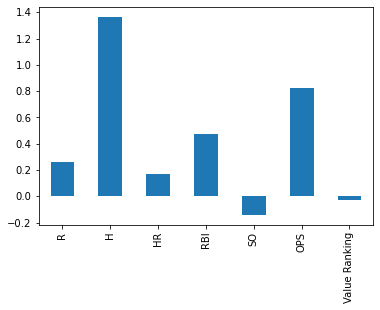

In [4]:
# Logistic Reg w alt features
model = Pipeline([
    ("std", StandardScaler()),
    ("logr", LogisticRegression())
])
model.fit(train[xcols_alt], train["allstars"])
model.score(test[xcols_alt], test["allstars"])

print(f"Train Accuracy: {model.score(train[xcols_alt], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {model.score(test[xcols_alt], test['allstars'])*100:0.3f}%")
pd.Series(model["logr"].coef_.reshape(-1), index=xcols_alt).plot.bar()

In [5]:
# Principal Component Analysis

df_pca = df[xcols].dropna()
pca = PCA(n_components = 16)
pca.fit(df_pca)
key_df = pd.DataFrame(pca.components_)
arr = pca.transform(df_pca)
data_df = pd.DataFrame(arr)
pca.explained_variance_ratio_.round(2)

array([0.86, 0.07, 0.03, 0.02, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [6]:
data_df = pd.DataFrame(pca.fit_transform(df_pca))
key_df = pd.DataFrame(pca.components_)
pca = PCA(n_components = 7)
data_df = pd.DataFrame(pca.fit_transform(df_pca))
key_df = pd.DataFrame(pca.components_)
pca.explained_variance_ratio_.round(3)

array([0.857, 0.073, 0.03 , 0.017, 0.009, 0.008, 0.004])

In [7]:
pca = PCA(n_components = 7, whiten = False)
data_df = pd.DataFrame(pca.fit_transform(df_pca))
key_df = pd.DataFrame(pca.components_)
pca.explained_variance_ratio_.round(3)

array([0.857, 0.073, 0.03 , 0.017, 0.009, 0.008, 0.004])

In [8]:
component_list = [1,2,3,4,5,6,7,8,9,10,11]

1     0.856697
2     0.929486
3     0.959513
4     0.976102
5     0.985542
6     0.993477
7     0.997180
8     0.998789
9     0.999860
10    0.999988
11    0.999999
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    1.000000
dtype: float64
1     0.475408
2     0.587524
3     0.679086
4     0.745657
5     0.807989
6     0.865296
7     0.912900
8     0.943769
9     0.973368
10    0.984398
11    0.991165
12    0.994479
13    0.997612
14    0.999396
15    0.999979
16    1.000000
dtype: float64


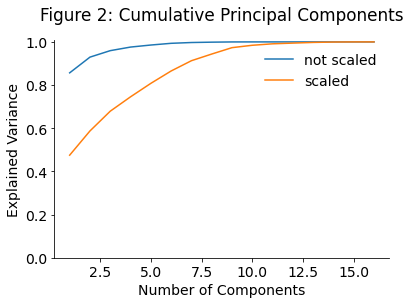

In [9]:
def explained(scale):
    stages = [("imp", SimpleImputer(strategy="most_frequent"))]
    if scale:
        stages.append(("std", StandardScaler()))
    stages.append(("pca", PCA()))
    p = Pipeline(stages)
    p.fit(df[xcols])
    #print(p["pca"].components_.round(2))
    explained = p["pca"].explained_variance_
    s = pd.Series(explained.cumsum() / explained.sum(),
                  index=range(1, len(xcols)+1))
    print(s)
    return s
plt.rcParams.update({'font.size': 14})
ax = explained(False).plot.line(label="not scaled", ylim=0)
explained(True).plot.line(label="scaled", ax=ax)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False)
ax.set_title("Figure 2: Cumulative Principal Components", pad=20)

plt.savefig("Fig 2.png", bbox_inches = 'tight')

In [10]:
# Knn

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train[xcols], train["allstars"])
print(f"Train Accuracy: {knn.score(train[xcols], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {knn.score(test[xcols], test['allstars'])*100:0.3f}%")
knn.fit(train[xcols_alt], train["allstars"])
print(f"Alt Train Accuracy: {knn.score(train[xcols_alt], train['allstars'])*100:0.3f}%")
print(f"Alt Valid Accuracy: {knn.score(test[xcols_alt], test['allstars'])*100:0.3f}%")

Train Accuracy: 93.773%
Valid Accuracy: 92.044%
Alt Train Accuracy: 93.544%
Alt Valid Accuracy: 91.770%


In [11]:
# Random Forest

clf = RandomForestClassifier(max_depth=12, random_state=0, n_estimators = 100, criterion = "gini", bootstrap = True, min_samples_split = 4, max_features = "sqrt")
clf.fit(train[xcols], train["allstars"])
print(f"Train Accuracy: {clf.score(train[xcols], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {clf.score(test[xcols], test['allstars'])*100:0.3f}%")
clf.fit(train[xcols_alt], train["allstars"])
print(f"Alt Train Accuracy: {clf.score(train[xcols_alt], train['allstars'])*100:0.3f}%")
print(f"Alt Valid Accuracy: {clf.score(test[xcols_alt], test['allstars'])*100:0.3f}%")

Train Accuracy: 99.771%
Valid Accuracy: 92.318%
Alt Train Accuracy: 99.542%
Alt Valid Accuracy: 92.181%


In [12]:
# Decision Tree

dtc = DecisionTreeClassifier(max_depth=12, max_features = "auto")
dtc.fit(train[xcols], train["allstars"])
print(f"Train Accuracy: {dtc.score(train[xcols], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {dtc.score(test[xcols], test['allstars'])*100:0.3f}%")
dtc.fit(train[xcols_alt], train["allstars"])
print(f"Alt Train Accuracy: {dtc.score(train[xcols_alt], train['allstars'])*100:0.3f}%")
print(f"Alt Valid Accuracy: {dtc.score(test[xcols_alt], test['allstars'])*100:0.3f}%")

Train Accuracy: 99.542%
Valid Accuracy: 89.163%
Alt Train Accuracy: 99.176%
Alt Valid Accuracy: 89.026%


In [13]:
# Grid Search for best params
dtc = DecisionTreeClassifier(random_state=123)

params =  {
    'min_samples_split': [1, 2, 3, 4],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 24, None],
    'max_features': ["auto","sqrt", "log2", None],
    'criterion': ["gini", "entropy"]
}

grid = GridSearchCV(estimator=dtc,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=1)

grid.fit(train[xcols], train['allstars'])

# Decision Tree with grid search params

dtc = DecisionTreeClassifier(max_depth = grid.best_params_['max_depth'],
                             max_features = grid.best_params_['max_features'],
                             min_samples_split = grid.best_params_['min_samples_split'], 
                             criterion = grid.best_params_['criterion'])
dtc.fit(train[xcols], train["allstars"])
print(f"Train Accuracy: {dtc.score(train[xcols], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {dtc.score(test[xcols], test['allstars'])*100:0.3f}%")

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
Train Accuracy: 92.537%
Valid Accuracy: 92.730%


c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
800 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\tree\_c

In [14]:
# Grid Search for best params w alt features
dtc = DecisionTreeClassifier(random_state=123)

params =  {
    'min_samples_split': [1, 2, 3, 4],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 24, None],
    'max_features': ["auto","sqrt", "log2", None],
    'criterion': ["gini", "entropy"]
}

grid = GridSearchCV(estimator=dtc,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=1)

grid.fit(train[xcols_alt], train['allstars'])

# Decision Tree with grid search params w alt features

dtc = DecisionTreeClassifier(max_depth = grid.best_params_['max_depth'],
                             max_features = grid.best_params_['max_features'],
                             min_samples_split = grid.best_params_['min_samples_split'], 
                             criterion = grid.best_params_['criterion'])
dtc.fit(train[xcols_alt], train["allstars"])
print(f"Train Accuracy: {dtc.score(train[xcols_alt], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {dtc.score(test[xcols_alt], test['allstars'])*100:0.3f}%")

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
Train Accuracy: 92.537%
Valid Accuracy: 92.730%


c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
800 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\users\edmo2\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\tree\_c

In [15]:
# MLP

mlp = MLPClassifier(random_state=0, max_iter = 300)
mlp.fit(train[xcols], train["allstars"])
print(f"Train Accuracy: {mlp.score(train[xcols], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {mlp.score(test[xcols], test['allstars'])*100:0.3f}%")
mlp.fit(train[xcols_alt], train["allstars"])
print(f"Alt Train Accuracy: {mlp.score(train[xcols_alt], train['allstars'])*100:0.3f}%")
print(f"Alt Valid Accuracy: {mlp.score(test[xcols_alt], test['allstars'])*100:0.3f}%")

Train Accuracy: 92.766%
Valid Accuracy: 91.084%
Alt Train Accuracy: 90.842%
Alt Valid Accuracy: 91.084%


In [16]:
# AdaBoost

ada = AdaBoostClassifier()
ada.fit(train[xcols], train["allstars"])
print(f"Train Accuracy: {ada.score(train[xcols], train['allstars'])*100:0.3f}%")
print(f"Valid Accuracy: {ada.score(test[xcols], test['allstars'])*100:0.3f}%")
ada.fit(train[xcols_alt], train["allstars"])
print(f"Alt Train Accuracy: {ada.score(train[xcols_alt], train['allstars'])*100:0.3f}%")
print(f"Alt Valid Accuracy: {ada.score(test[xcols_alt], test['allstars'])*100:0.3f}%")

Train Accuracy: 93.407%
Valid Accuracy: 91.221%
Alt Train Accuracy: 93.315%
Alt Valid Accuracy: 92.181%


In [17]:
def optimization_objective(trial, X_train, y_train, cv=5):

    
    params =  {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0.0, 0.5),
        'max_depth': trial.suggest_categorical('max_depth', [6, 16, None])
    }

    cv_iterator = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)

    cv_scores = np.zeros(cv)
    for idx, (train_sub_idx, valid_idx) in enumerate(cv_iterator.split(X_train, y_train)):
        
        X_train_sub, X_valid = X_train[train_sub_idx], X_train[valid_idx]
        y_train_sub, y_valid = y_train[train_sub_idx], y_train[valid_idx]
        

        model = DecisionTreeClassifier(**params, random_state=123)
        model.fit(X_train_sub, y_train_sub)
        preds = model.score(X_valid, y_valid)
        
        cv_scores[idx] = preds

    return np.mean(cv_scores)